Using TensorFlow backend.


UMPM


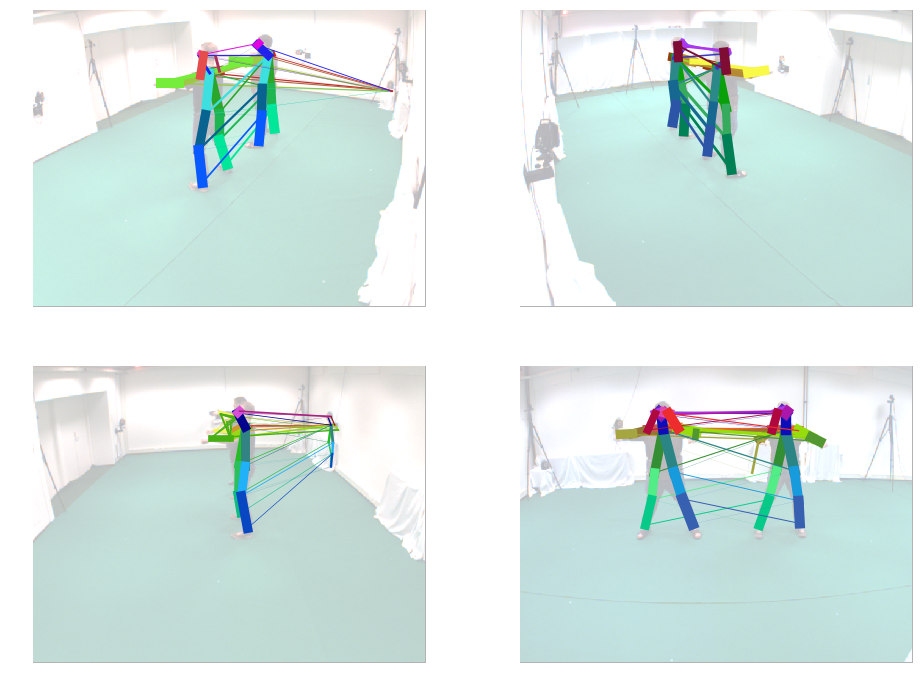

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.append('./../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][0], X[1][0], X[2][0], X[3][0]])
with_gpu = False

if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    if isfile('/tmp/heatmaps.npy') and isfile('/tmp/pafs.npy'):
        heatmaps = np.load('/tmp/heatmaps.npy')
        pafs = np.load('/tmp/pafs.npy')
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save('/tmp/heatmaps.npy', heatmaps)
        np.save('/tmp/pafs.npy', pafs)
        
import mvpose.plot.limbs as pltlimbs

fig = plt.figure(figsize=(16,12))

Calib_undist = []
Peaks_undist = []
Peaks = []
Limb_Weights = []

for cid, cam in enumerate(Calib):
    hm = heatmaps[cid]
    paf = pafs[cid]
    peaks = mvhm.get_all_peaks(hm)
    Peaks.append(peaks)
    limbs = mvpafs.calculate_limb_weights(peaks, paf)
    Limb_Weights.append(limbs)
    ax = fig.add_subplot(2,2,cid+1)
    pltlimbs.plot(ax, Im[cid], peaks, limbs); ax.axis('off')
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    hm_ud, K_ud = gm.remove_distortion(hm, cam)     # TODO make this faster... this is not effiencent
#     peaks_undist = mvhm.get_all_peaks(hm_ud)        # ...
#     Peaks_undist.append(peaks_undist)
    
#     assert peaks_undist.n_joints == peaks.n_joints
#     for __k in range(peaks_undist.n_joints):
#         p1 = peaks[__k]
#         p2 = peaks_undist[__k]
#         assert p1.shape == p2.shape, 'k:' + str(__k)
    
    Calib_undist.append({
        'K': K_ud,
        'distCoeff': 0,
        'rvec': rvec,
        'tvec': tvec
    })
    
plt.show()

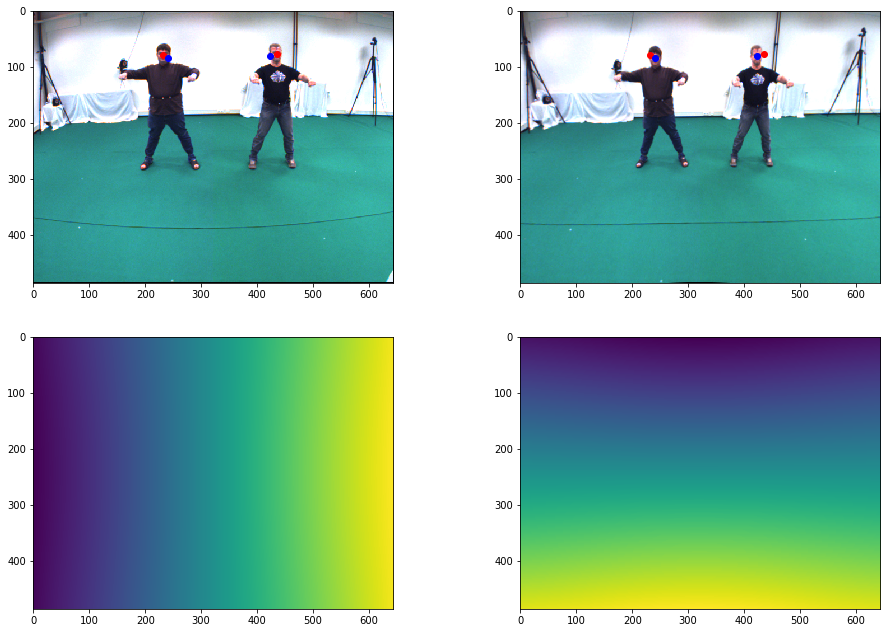

In [2]:
from mvpose.candidates import peaks as mvpeaks

cam = 3

K, rvec, tvec, distCoef = gm.get_camera_parameters(Calib[cam])
K_new = Calib_undist[cam]['K']

I = Im[cam]
h,w,_ = I.shape

mapx, mapy = \
    cv2.initUndistortRectifyMap(K, distCoef, None, K_new, (w, h), 5)

peaks = Peaks[cam]
Nose = peaks[0]

peaks_undist = mvpeaks.Peaks.undistort(peaks, mapx, mapy)

Nose_undist = peaks_undist[0]
        
# ------------
fig = plt.figure(figsize=(16,11))

ax = fig.add_subplot(221); ax.imshow(I)
ay = fig.add_subplot(222); ay.imshow(cv2.remap(I, mapx, mapy, cv2.INTER_LINEAR))
for x,y,_ in Nose:
    ax.scatter(x,y,color='red')
    ay.scatter(x,y,color='red')
    
for x,y,_ in Nose_undist:
    ax.scatter(x,y,color='blue')
    ay.scatter(x,y,color='blue')

fig.add_subplot(223).imshow(mapx)
fig.add_subplot(224).imshow(mapy)